# PART 2

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

# Import the Porter stemmer
from nltk.stem.porter import *

from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phuon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\phuon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phuon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### a. Initial cleaning
For later usage, skip this part and go to part b

In [ ]:
# SKIP THIS PART IF DON'T WANT TO WAIT FOR THE DATA TO LOAD
tw_data = pd.read_csv('Twitter_Jan_Mar.csv')
tw_data.head()

,date,id,content,username,like_count,retweet_count
0,2023-03-29 22:58:21+00:00,1641213230730051584,"Free AI marketing and automation tools, strate...",RealProfitPros,0.0,0.0
1,2023-03-29 22:58:18+00:00,1641213218520481805,@MecoleHardman4 Chat GPT says it’s 15. 😂,AmyLouWho321,0.0,0.0
2,2023-03-29 22:57:53+00:00,1641213115684536323,https://t.co/FjJSprt0te - Chat with any PDF!\n...,yjleon1976,0.0,0.0
3,2023-03-29 22:57:52+00:00,1641213110915571715,"AI muses: ""In the court of life, we must all f...",ChatGPT_Thinks,0.0,0.0
4,2023-03-29 22:57:26+00:00,1641213003260633088,Most people haven't heard of Chat GPT yet.\nFi...,nikocosmonaut,0.0,0.0


In [38]:
tw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500036 entries, 0 to 500035
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           500036 non-null  object 
 1   id             500030 non-null  object 
 2   content        500030 non-null  object 
 3   username       500002 non-null  object 
 4   like_count     499974 non-null  float64
 5   retweet_count  499974 non-null  float64
dtypes: float64(2), object(4)
memory usage: 22.9+ MB


In [39]:
# drop missing labels
tw_data = tw_data.dropna()

# remove unused columns
tw_data = tw_data.drop(columns=['id', 'username', 'retweet_count'])

# check if there is any missing data left
tw_data.isnull().sum()

date          0
content       0
like_count    0
dtype: int64

In [40]:
# Code copied from part 1 but made some changes on names/values

# Create a new column in our DF that contains token lists instead of raw text
def tokenize_text(df):
  df['tokens'] =  df["content"].apply(lambda x: x.split())

# Remove any URL tokens
def remove_url(df):
  df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if not re.match(r'http\S+', word)])

# NEW: Remove any additional tokens related to chatgpt
def remove_chatgpt(df):
  chatgpt_terms = {'chat', 'chat gpt', 'chatgpt', 'gpt', 'gpt-4', 'gpt4', 'gpt3', 'openai'}

  df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word.lower() not in chatgpt_terms and 
                                                    not re.match(r'^[@#]\S+', word)])


# Remove all punctuation (,.?!;:’") and special characters(@, #, +, &, =, $, etc). Also, convert all tokens to lowercase only. 
def add_cleaned_tokens(df):
    cleaned_tokens = []
    for row in df['tokens']:
      cleaned_tokens.append([re.sub(r'[^a-zA-Z0-9]', '', t).lower() for t in row if re.sub(r'[^a-zA-Z0-9]', '', t)])
    df['cleaned_tokens'] = cleaned_tokens

# Stemm tokens by the Porter stememr
def stem_tokens(df):
  stemmer = PorterStemmer()
  df['stemmed_tokens'] = df['cleaned_tokens'].apply(lambda tokens: [stemmer.stem(t) for t in tokens])

# Remove stopwords in english
def remove_stopwords(df):
  sw = stopwords.words('english')
  tokens_no_sw = []
  for row in df['stemmed_tokens']:
    tokens_no_sw.append([t for t in row if t not in sw])
  df['tokens_no_sw'] = tokens_no_sw


In [41]:
# Process the data by going through all the steps from tokenization -> remove special characters -> stemming -> stopwords
def process_data(df):
  tokenize_text(df)
  remove_url(df)
  remove_chatgpt(df)
  add_cleaned_tokens(df)
  stem_tokens(df)
  remove_stopwords(df)
  return df

tw_data = process_data(tw_data)

tw_data.head()

,date,content,like_count,tokens,cleaned_tokens,stemmed_tokens,tokens_no_sw
0,2023-03-29 22:58:21+00:00,"Free AI marketing and automation tools, strate...",0.0,"[Free, AI, marketing, and, automation, tools,,...","[free, ai, marketing, and, automation, tools, ...","[free, ai, market, and, autom, tool, strategi,...","[free, ai, market, autom, tool, strategi, coll..."
1,2023-03-29 22:58:18+00:00,@MecoleHardman4 Chat GPT says it’s 15. 😂,0.0,"[says, it’s, 15., 😂]","[says, its, 15]","[say, it, 15]","[say, 15]"
2,2023-03-29 22:57:53+00:00,https://t.co/FjJSprt0te - Chat with any PDF!\n...,0.0,"[-, with, any, PDF!, Check, out, how, this, ne...","[with, any, pdf, check, out, how, this, new, a...","[with, ani, pdf, check, out, how, thi, new, ai...","[ani, pdf, check, thi, new, ai, quickli, answe..."
3,2023-03-29 22:57:52+00:00,"AI muses: ""In the court of life, we must all f...",0.0,"[AI, muses:, ""In, the, court, of, life,, we, m...","[ai, muses, in, the, court, of, life, we, must...","[ai, muse, in, the, court, of, life, we, must,...","[ai, muse, court, life, must, face, judg, dest..."
4,2023-03-29 22:57:26+00:00,Most people haven't heard of Chat GPT yet.\nFi...,0.0,"[Most, people, haven't, heard, of, yet., First...","[most, people, havent, heard, of, yet, first, ...","[most, peopl, havent, heard, of, yet, first, e...","[peopl, havent, heard, yet, first, elit, facti..."


In [42]:
# clear unused column, renamed the final cleaned column
tw_data['cleaned_content'] = tw_data['tokens_no_sw']
tw_data = tw_data.drop(columns=['tokens', 'cleaned_tokens', 'stemmed_tokens', 'tokens_no_sw'])

# convert to a csv file so that we don't have to run and wait raw data again
tw_data.to_csv("twitter_cleaned.csv", index = False)

### b. Vectorization and Clustering

In [60]:
# Run this instead of part (a) for future attempts
tw_data = pd.read_csv('twitter_cleaned.csv')

# set the 'date' column to datetime format
tw_data['date'] = pd.to_datetime(tw_data['date'], utc=True)

# set 'date' as the index 
tw_data.set_index('date', inplace=True)
tw_data

,content,like_count,cleaned_content
date,,,
2023-03-29 22:58:21+00:00,"Free AI marketing and automation tools, strate...",0.0,"['free', 'ai', 'market', 'autom', 'tool', 'str..."
2023-03-29 22:58:18+00:00,@MecoleHardman4 Chat GPT says it’s 15. 😂,0.0,"['say', '15']"
2023-03-29 22:57:53+00:00,https://t.co/FjJSprt0te - Chat with any PDF!\n...,0.0,"['ani', 'pdf', 'check', 'thi', 'new', 'ai', 'q..."
2023-03-29 22:57:52+00:00,"AI muses: ""In the court of life, we must all f...",0.0,"['ai', 'muse', 'court', 'life', 'must', 'face'..."
2023-03-29 22:57:26+00:00,Most people haven't heard of Chat GPT yet.\nFi...,0.0,"['peopl', 'havent', 'heard', 'yet', 'first', '..."
...,...,...,...
2023-01-04 07:18:08+00:00,@GoogleAI #LAMDA Versus @OpenAI #ChatGPT ?! Wh...,1.0,"['versu', 'care', 'lamda', 'isnt', 'avail', 'r..."
2023-01-04 07:17:50+00:00,#ChatGPT \n\nSo much #Censorship.\n\nNever tru...,2.0,"['much', 'never', 'trust', 'system', 'dont', '..."
2023-01-04 07:17:20+00:00,all my twitter feed is about ChatGPT and @Open...,3.0,"['twitter', 'feed', 'lol']"


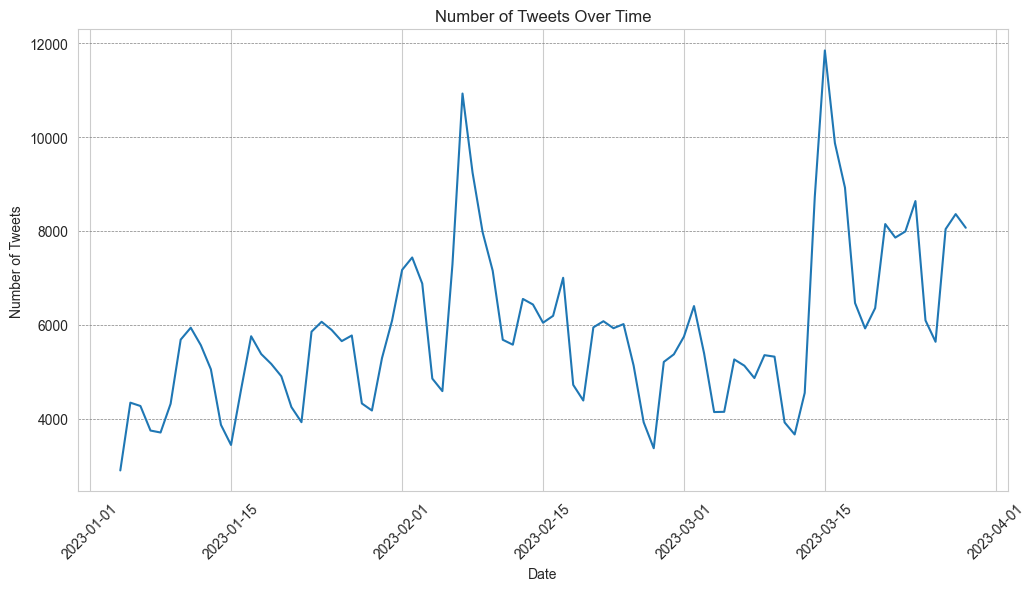

In [61]:
# Group the number of tweets per day
tweets_per_day = tw_data.resample('D').size()

# Plot the number of tweets over time
plt.figure(figsize=(12, 6))
plt.plot(tweets_per_day.index, tweets_per_day.values, linestyle='-')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets Over Time')

# Customize x-axis to show more dates
plt.xticks(rotation=45)

# Customize grid to be horizontal dash lines
plt.grid(axis='y', linestyle='--', color='gray', linewidth=0.5)

plt.show()

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
def count_vectorizer(df):
  X_df = df['cleaned_content'].to_numpy()
  vocab_count = X_df.shape[0]

  print(f"The length of vocabulary is: {vocab_count}")

  count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= None,
    token_pattern= None,
    max_features = vocab_count)

  counts = count_vec.fit_transform(X_df)

  print(f"vec: {counts.toarray()}")
  print(f"vec shape: {counts.shape}")
  return counts

In [63]:
vec = count_vectorizer(tw_data)

The length of vocabulary is: 499974


vec: [[ 9 20  9 ...  0  0  0]
 [ 1  4  1 ...  0  1  0]
 [14 30 14 ...  0  0  0]
 ...
 [ 2  6  2 ...  0  0  0]
 [ 9 20  9 ...  0  0  1]
 [ 9 20  9 ...  0  1  0]]
vec shape: (499974, 41)


In [46]:
# # Vectorizing using TF-IDF vectors
# from sklearn.feature_extraction.text import TfidfVectorizer

# # TF-IDF Vectorizer
# vectorizer = TfidfVectorizer(lowercase=True,
#                                 #max_features=100,
#                                 # max_df=0.99,
#                                 # min_df=1,
#                                 ngram_range = (1,3),
#                                 stop_words = "english"
#                             )

# # fit the model to the tweet data
# vectors = vectorizer.fit_transform(tw_data)

# vectors.shape

In [64]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()

# TF-IDF Vectorizer
def tfidf_vectorizer(counts):
    tfidf_data = tfidf.fit_transform(counts)
    print(f"TF-IDF vec shape: {tfidf_data.shape}")

    return tfidf_data

In [65]:
# Apply TF-IDF Vectorizer to the train and test data
tfidf_data = tfidf_vectorizer(vec)

TF-IDF vec shape: (499974, 41)


In [7]:
tfidf_data

<499974x41 sparse matrix of type '<class 'numpy.float64'>'
	with 10825494 stored elements in Compressed Sparse Row format>

Yiwei Tried something

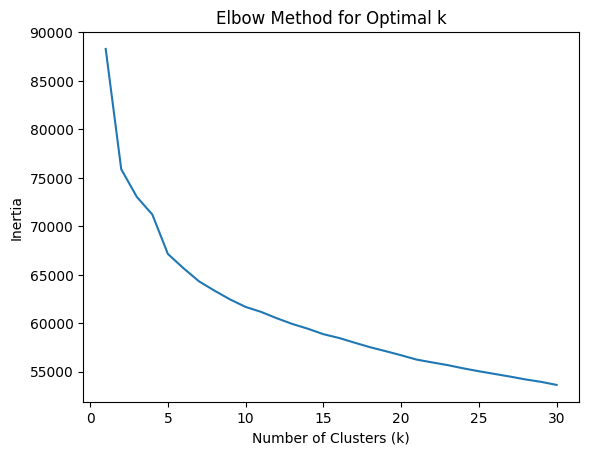

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def plot_elbow_method(tfidf_data):
    # Using Elbow Method to find the optimal k
    inertia = []
    for k in range(1, 31):  
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tfidf_data)
        inertia.append(kmeans.inertia_)
    
    # Plotting the Elbow graph
    plt.plot(range(1, 31), inertia)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()

# Plot Elbow method
plot_elbow_method(tfidf_data)

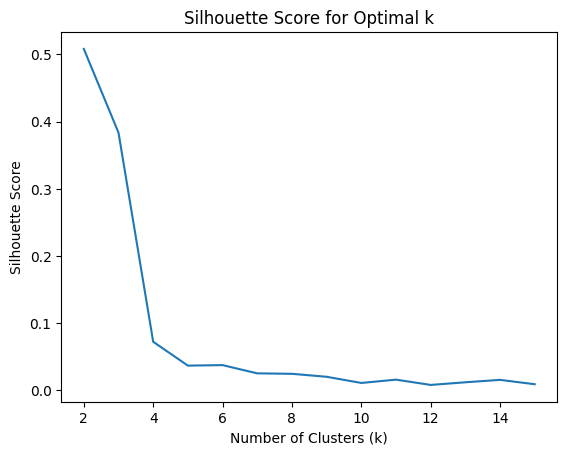

In [9]:
from sklearn.utils import resample
def plot_silhouette_score(tfidf_data):
    silhouette_scores = []
    k_values = range(2, 16)
    
    for k in k_values:
        sampled_data = resample(tfidf_data, n_samples=5000, random_state=42)
        kmeans = KMeans(n_clusters=k, n_init = 2, init="random", max_iter = 300, random_state=42)
        kmeans.fit(sampled_data)
        score = silhouette_score(sampled_data, kmeans.labels_)
        silhouette_scores.append(score)
    
    # Plot Silhouette scores
    plt.plot(range(2, 16), silhouette_scores)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.show()

# Plot Silhouette score
plot_silhouette_score(tfidf_data)

The elbow curve and sihouetter score both give consistent results of the optimate number of clusters: around 4.

In [66]:
import re
from sklearn.cluster import KMeans

# Custom tokenizer function using regex
def custom_tokenizer(text):
    # Keep only alphabetic characters and split by spaces
    return re.findall(r'\b[a-zA-Z]+\b', text.lower())

# Using TfidfVectorizer with the custom tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def tfidf_vectorizer(df):
    X_df = df['cleaned_content'].to_numpy()

    # Initialize the TfidfVectorizer with the custom tokenizer
    tfidf_vec = TfidfVectorizer(analyzer='word', tokenizer=custom_tokenizer, stop_words='english')

    # Fit and transform the data into the TF-IDF matrix
    tfidf_data = tfidf_vec.fit_transform(X_df)

    # Get feature names to see the actual terms
    feature_names = tfidf_vec.get_feature_names_out()
    #print("Vocabulary (first 10 words):", feature_names[:10])  # Print the first 10 terms

    return tfidf_data, feature_names

# Test the TF-IDF vectorizer with a small sample of the data
tfidf_data, feature_names = tfidf_vectorizer(tw_data)

# Now we can apply KMeans to cluster the data and see which terms are important for each cluster

# Let's fit KMeans clustering on the TF-IDF data
n_clusters = 4  # prev: 11
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(tfidf_data)

# store the labels
tw_data['cluster'] = kmeans.labels_

c:\Users\phuon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [67]:
def print_top_terms_per_cluster(kmeans, terms, top_n=50):
    cluster_word_data = {}

    for i in range(kmeans.n_clusters):
        print(f"Cluster {i}:")
        cluster_centroid = kmeans.cluster_centers_[i]
        top_indices = cluster_centroid.argsort()[-top_n:][::-1]  # Get indices of top terms
        top_terms = {terms[index]: cluster_centroid[index] for index in top_indices}
        
        # Store in dictionary
        cluster_word_data[i] = top_terms

        print("Top terms:", ", ".join(top_terms.keys()))
        print()

    return cluster_word_data

cluster_text = print_top_terms_per_cluster(kmeans, feature_names)

Cluster 0:
Top terms: ask, gpt, like, chatgpt, ha, new, write, know, make, googl, wa, answer, time, think, work, amp, say, tri, question, need, help, prompt, gener, human, good, look, whi, learn, futur, im, power, read, creat, way, world, come, better, dont, peopl, search, day, thing, model, thank, bing, code, doe, intellig, job, microsoft

Cluster 1:
Top terms: thi, use, wa, like, ai, ask, write, ha, think, new, make, know, gpt, time, check, im, thing, articl, work, week, question, learn, help, read, answer, look, chatgpt, tri, gener, dont, need, tweet, technolog, way, amp, prompt, peopl, whi, year, good, tool, say, creat, want, model, realli, let, post, thread, video

Cluster 2:
Top terms: use, write, tool, make, way, creat, ai, gener, help, learn, gpt, like, content, chatgpt, work, code, case, peopl, student, know, time, prompt, im, start, dont, new, ha, model, busi, tri, think, amp, api, ask, languag, idea, googl, wa, need, thi, develop, want, good, product, question, ive, market, 

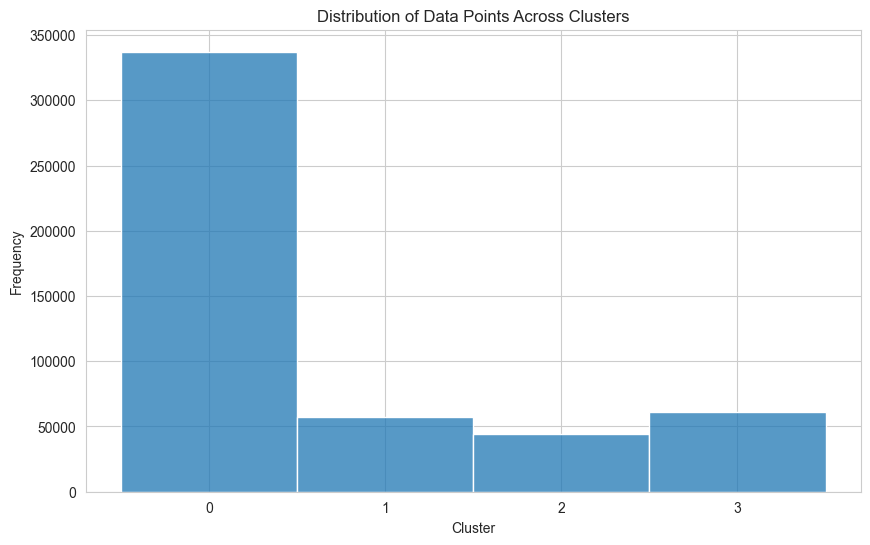

In [69]:
# Set the style
sns.set_style("whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(tw_data['cluster'], bins=n_clusters, discrete=True, kde=False)

# Customize the plot
plt.xlabel("Cluster")
plt.ylabel("Frequency")
plt.title("Distribution of Data Points Across Clusters")
plt.xticks(range(n_clusters))  # Ensure all clusters are represented on the x-axis

# Show the plot
plt.show()

The imbalance between the number of tweets in each cluster means either:
1. There were many tweets with similar topics
2. These clusters contain mainly vague words that are not unique

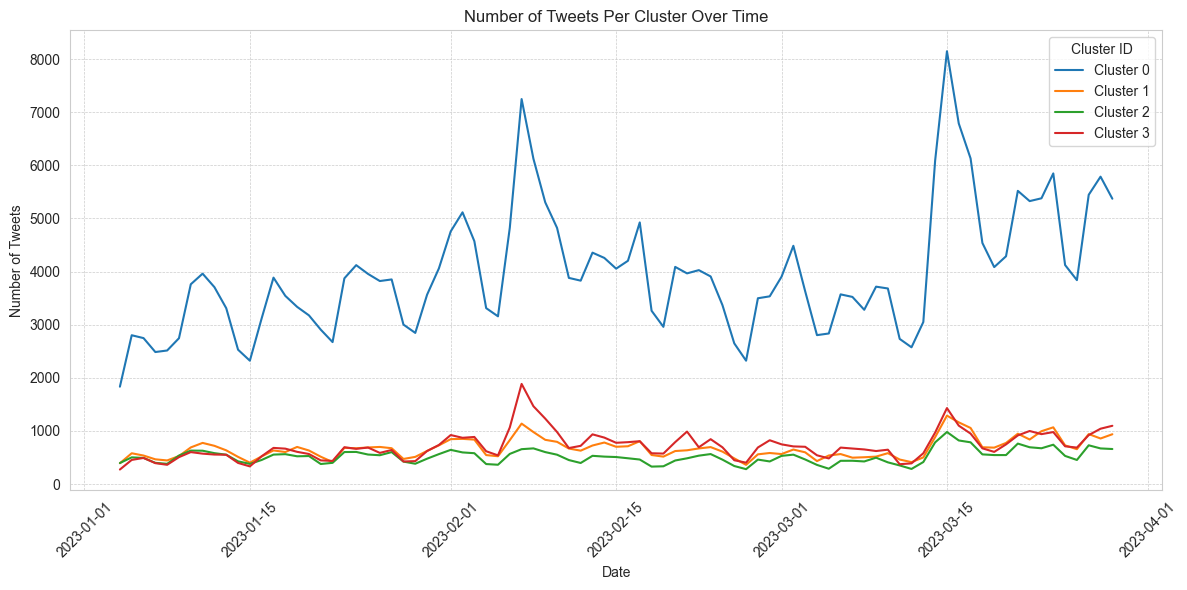

In [70]:
# Group by date and cluster, then count the number of tweets for each combination
tweets_per_day_by_cluster = tw_data.groupby([tw_data.index.date, 'cluster']).size().unstack(fill_value=0)

# Plot the number of tweets per day for each cluster
plt.figure(figsize=(12, 6))

# Plot each cluster's tweet count
for cluster_id in tweets_per_day_by_cluster.columns:
    plt.plot(tweets_per_day_by_cluster.index, tweets_per_day_by_cluster[cluster_id], label=f"Cluster {cluster_id}")

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets Per Cluster Over Time')
plt.xticks(rotation=45)
plt.legend(title='Cluster ID')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

Cluster 0 has significantly many tweets than any other clusters.

Other topics/clusters were roughly equally discussed.

Noticeably, the peaks seem to be consistent among each clusters, with the most discussed periods be Mid March 2023 and around 7th February 2023.

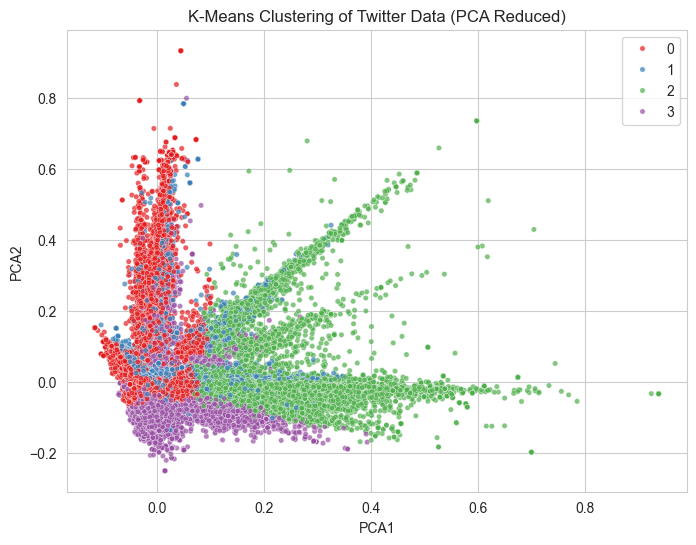

In [71]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Perform PCA to reduce dimensionality to 2D (work directly with sparse matrix)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(tfidf_data)  # No need to convert to array

# Create a DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = kmeans.labels_

# Visualize the clusters in 2D space with additional enhancements
plt.figure(figsize=(8, 6))

# Plot the clusters with different colors
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='Set1', s=15, alpha=0.7)

# Plot the centroids of each cluster in the PCA space
# centroids = pca.transform(kmeans.cluster_centers_)  # Transform centroids to 2D PCA space
# plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')

# Add labels to the points (optional, can be commented out for clarity)
# for i in range(len(pca_df)):
#     plt.text(pca_df.PCA1[i], pca_df.PCA2[i], str(i), fontsize=9)

plt.title('K-Means Clustering of Twitter Data (PCA Reduced)')
plt.legend(loc='best')
plt.show()


In [19]:
import ast
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

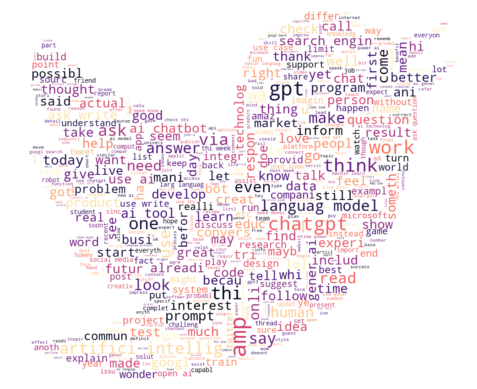

In [ ]:
twitter_mask = np.array(Image.open('./Twitter.png'))

text = " ".join(" ".join(ast.literal_eval(content)) for content in tw_data['cleaned_content'])
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white",contour_color = 'white', colormap = 'magma', mask = twitter_mask).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [75]:
# Convert string lists to actual lists
tw_data['cleaned_content'] = tw_data['cleaned_content'].apply(ast.literal_eval)

In [76]:
from collections import defaultdict

cluster_texts = defaultdict(list)  # Store words as lists

for cluster_id, text in zip(tw_data['cluster'], tw_data['cleaned_content']):
    cluster_texts[cluster_id].extend(text)  # Append text instead of concatenating

# Convert lists to strings efficiently
for cluster_id in cluster_texts:
    cluster_texts[cluster_id] = " ".join(cluster_texts[cluster_id])

print(cluster_texts[0][:200])

say 15 peopl havent heard yet first elit faction decid way go ai safeti next push agenda public mislead oversimplifi media present final brainless red blue camp screech line ha put togeth amaz recip p


In [73]:
def plot_wordcloud(cluster_texts, cluster_id):
    if cluster_id not in cluster_texts:
        print(f"Cluster {cluster_id} not found.")
        return
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(cluster_texts[cluster_id])

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()

In [74]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# function to add widgets and handle interactions
def add_widget(cluster_texts):
    # Dropdown widget to select a cluster
    start_widget = widgets.Dropdown(
        options=sorted([str(c) for c in cluster_texts.keys()] + ['ALL']),
        value='ALL',
        description='Select Cluster:',
    )

    # Observe changes in dropdown selection
    start_widget.observe(lambda d: plot_wordcloud_by_cluster(d['new'], cluster_texts), 'value')
    display(start_widget)

# function to handle the dropdown value and plot the word cloud
def plot_wordcloud_by_cluster(cluster_id, cluster_texts):
    clear_output(wait=True)
    add_widget(cluster_texts)  # Redraw the widget
    if cluster_id == 'ALL':
        # If 'ALL' is selected, generate word cloud for all clusters combined
        all_text = " ".join(cluster_texts.values())
        plot_wordcloud({0: all_text}, 0)  # Plot a combined word cloud for all clusters
    else:
        # Plot word cloud for selected cluster
        plot_wordcloud(cluster_texts, int(cluster_id))

add_widget(cluster_texts)

Dropdown(description='Select Cluster:', index=4, options=('0', '1', '2', '3', 'ALL'), value='ALL')

Note that after selecting the widget values, it will take a while to load the wordcloud. Here we have included the wordclouds separately for each clusters for convenience.

While the colors and positions of the words might be different due to randomness, the wordclouds are still consistent regarding the popularity order of the words in the clusters, sorted by sizes.

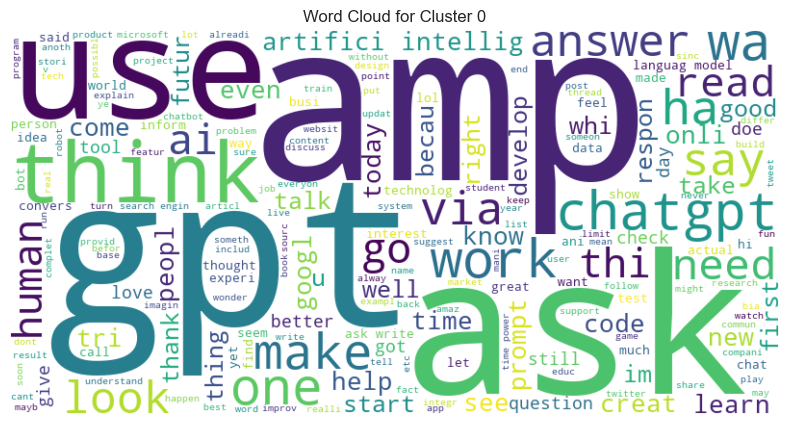

In [32]:
plot_wordcloud(cluster_texts, 0) # Change cluster_id to visualize other clusters

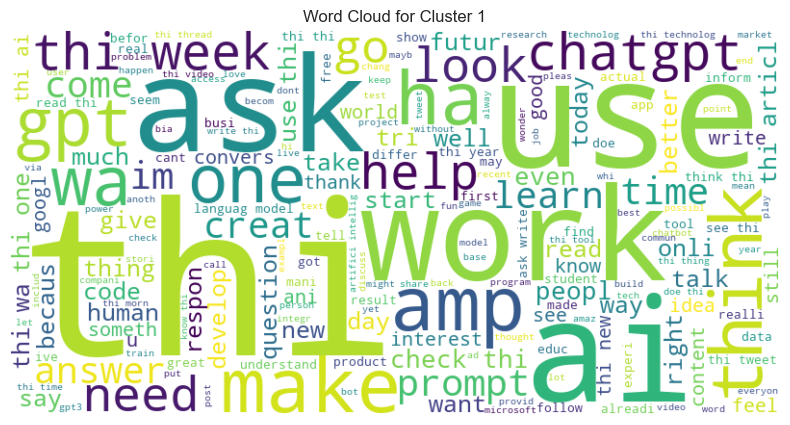

In [33]:
plot_wordcloud(cluster_texts, 1) # Change cluster_id to visualize other clusters

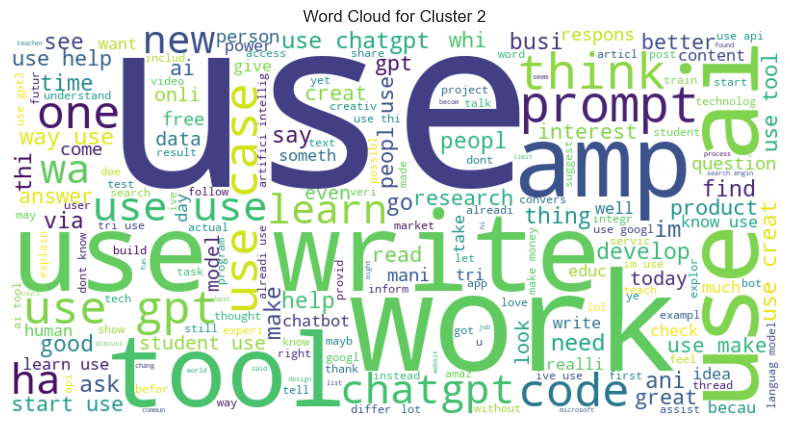

In [34]:
plot_wordcloud(cluster_texts, 2) # Change cluster_id to visualize other clusters